# Classification model

In [3]:
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('pnd_features_new.csv', index_col=0)

In [5]:
# make one hot vector for coin and channel
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
def one_hot(df, col):
    col = df[col]
    col = preprocessing.LabelEncoder().fit_transform(col).reshape(-1,1)
    col = OneHotEncoder().fit_transform(col).toarray()
    return col
channel = one_hot(df, 'Channel')

In [6]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [7]:
X = np.concatenate([df[['month_cos', 'month_sin', 'hour_cos','hour_sin', 'yobit', 'bittrex', 'cryptopia', '2019year', '2020year', '2021year']].values, channel], axis =1)
Y = df['success'].values
X.shape

(1222, 124)

In [8]:
# split the data into train data (80%) and test data (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [9]:
class Model():
    def __init__(self, model, X_train = X_train, Y_train = Y_train):
        self.model = model
        self.xtrain = X_train
        self.ytrain = Y_train
    
    def train(self, params):
        self.params = params

        # adjust hyperparameters through gridsearch
        self.grid_search = GridSearchCV(self.model, self.params, cv=StratifiedKFold(n_splits=5, random_state=1).split(self.xtrain, self.ytrain), 
                           verbose=1, n_jobs=1) 
        self.clf = self.grid_search.fit(self.xtrain, self.ytrain)
        print(self.clf.best_params_)
  
    def predict(self, X_test = X_test, Y_test = Y_test):
        self.xtest = X_test
        self.ytest = Y_test
        self.predict = self.clf.predict(self.xtest)
        print(classification_report(self.ytest, self.predict))

    def make_matrix(self, name):
        matrix = confusion_matrix(self.ytest, self.predict)[::-1][:, ::-1]
        proportions = np.zeros((2,2))
        for i in range(0,2):
            proportions[i,:] = matrix[i,:] / float(matrix[i,:].sum())
        names = ['successful', 'unsuccessful']
        confusion_df = pd.DataFrame(proportions, index=names, columns=names)
        plt.figure(figsize=(5,5))
        seaborn.heatmap(confusion_df, annot=True, annot_kws={"size": 14}, cmap='Blues', square=True, fmt='.2f')
        plt.title("confusion matrix (%)", fontsize=20)
        plt.xlabel('Prediction', fontsize=16)
        plt.ylabel('True', fontsize=16)
        plt.tick_params(labelsize=12)
        plt.savefig('img/{}.jpg'.format(name))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   18.5s finished


{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 25}
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       131
           1       0.75      0.71      0.73       114

    accuracy                           0.76       245
   macro avg       0.75      0.75      0.75       245
weighted avg       0.75      0.76      0.75       245



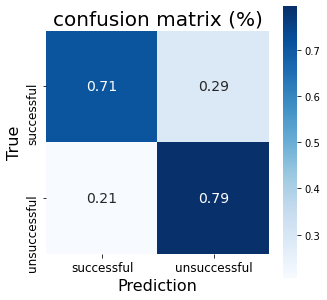

In [10]:
rf = Model(RandomForestClassifier(class_weight ='balanced', random_state = 1))
rf_params ={
    'criterion': ['gini', 'entropy'],
    'max_depth':  [10, 15, 20, None],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [5,10,15,20,25]}
rf.train(rf_params)
rf.predict()
rf.make_matrix('RandomForest')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.6min finished


{'xg__colsample_bytree': 0.5, 'xg__learning_rate': 0.1, 'xg__max_depth': 2, 'xg__subsample': 0.5}
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       131
           1       0.76      0.65      0.70       114

    accuracy                           0.74       245
   macro avg       0.74      0.73      0.73       245
weighted avg       0.74      0.74      0.74       245



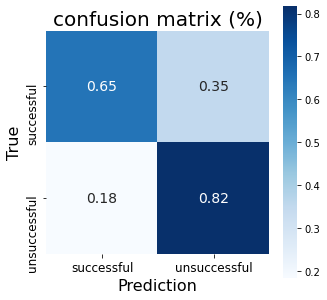

In [11]:
import xgboost as xgb
xg = Model(xgb.XGBClassifier(class_weight = 'balanced', random_state = 1))
xg_params = {"xg__learning_rate":[0.1,0.3,0.5],
        "xg__max_depth": [2,3,5,10],
         "xg__subsample":[0.5,0.8,0.9,1],
         "xg__colsample_bytree": [0.5,1.0],
         }
xg.train(xg_params)
xg.predict()
xg.make_matrix('XGBoost')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    5.6s finished


{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}
              precision    recall  f1-score   support

           0       0.78      0.73      0.76       131
           1       0.71      0.76      0.74       114

    accuracy                           0.75       245
   macro avg       0.75      0.75      0.75       245
weighted avg       0.75      0.75      0.75       245



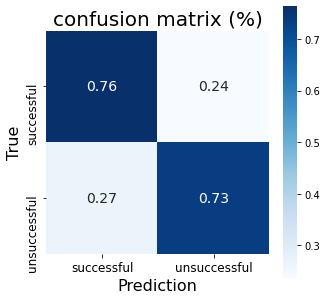

In [12]:
import lightgbm as lgb
lg = Model(lgb.LGBMClassifier(class_weight = 'balanced', random_state =1))
lg_params = {"learning_rate":[0.1,0.3,0.5],
        "max_depth": [2,3,5,10],
         "subsample":[0.5,0.8,0.9,1],
         }
lg.train(lg_params)
lg.predict()
lg.make_matrix('LightGBM')